In [5]:
from collections import Counter
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from operator import itemgetter
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from textatistic import Textatistic
from textblob import TextBlob
from textblob import Word
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud
import imageio
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import statsmodels.api as sm

## 1. Lending Club Logistic Regression

In [6]:
df = pd.read_csv('club.csv')

In [7]:
df.head(5)

,credit_policy,purpose,int_rate,installment,log_annual_income,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## A. What is the expected outcome for EACH X variable on defaulting? Will it increase the probability, decrease the probability, or unknown effect? 

In [8]:
df.describe()

,credit_policy,int_rate,installment,log_annual_income,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


credit_policy: Negative relationship. If they do not meet Lending Club's credit policy, it is probably not a good sign they will pay back their loan

purpose: There are 7 groups here and they can vary. Hard to say what the effect of each group is

int_rate: Higher interest rate, higher chance of not paying back

installment: Higher payments, higher chance of not paying back

log_annual_income: Higher annual income, lower chance of not paying back

dti: Higher debt to income ratio, higher chance of not paying back

fico: Higher FICO, lower chance of not paying back

days_with_cr_line: More days with credit line, higher chance of not paying back

revol_bal: Higher revolving balance, higher chance of not paying back

revol_util: Higher percent of credit line used, higher chance of not paying back

inq_last_6mths: More creditors calling them, higher chance of them not paying back

delinq_2yrs: More times failed to pay, higher chance of them not paying back

pub_rec: More negative reports, higher chance of them not paying back

## B. Transform any non-numeric variables into numeric for use in a logistic regression.

In [9]:
pd.get_dummies(df['purpose'])

,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
9573,1,0,0,0,0,0,0
9574,1,0,0,0,0,0,0
9575,0,0,1,0,0,0,0
9576,0,0,0,0,1,0,0


There are 7 categories under "purpose" so we need to make 6 dummy variables (catergories minus one). Let's create one for each of the groups and leave "all_other" as the default level.

In [10]:
df['credit_card']=pd.get_dummies(df['purpose'])['credit_card']
df['debt_consolidation']=pd.get_dummies(df['purpose'])['debt_consolidation']
df['educational']=pd.get_dummies(df['purpose'])['educational']
df['home_improvement']=pd.get_dummies(df['purpose'])['home_improvement']
df['major_purchase']=pd.get_dummies(df['purpose'])['major_purchase']
df['small_business']=pd.get_dummies(df['purpose'])['small_business']

## C. Run the summary statistics to check for complete data, no outliers, and sufficient sample size.

In [11]:
df.describe()

,credit_policy,int_rate,installment,log_annual_income,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054,0.131760,0.413134,0.035811,0.065671,0.045625,0.064627
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676,0.338248,0.492422,0.185829,0.247720,0.208682,0.245880
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It all looks pretty reasonable. However it does look like someone keeps a revolving balance of 1.2 million dollars which is pretty large. Let's examine with a histogram.

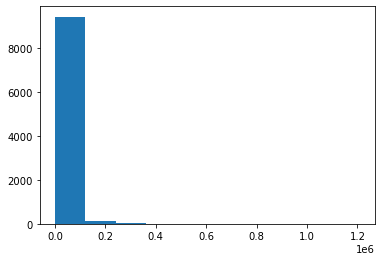

In [12]:
plt.hist(df['revol_bal'])
plt.show()

That is pretty extreme. Let's find out where the outliers are. Let's check for revolving balances above $500k

In [13]:
df.loc[df['revol_bal']>500000]

,credit_policy,purpose,int_rate,installment,log_annual_income,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
9042,0,small_business,0.2011,735.06,13.304685,14.39,672,7620.000000,952013,99.0,6,0,0,0,0,0,0,0,0,1
9149,0,all_other,0.1411,513.44,12.234427,23.46,697,13920.000000,508961,91.7,0,0,0,1,0,0,0,0,0,0
9307,0,all_other,0.1287,168.17,12.594731,9.27,692,6330.000000,602519,68.4,4,0,1,0,0,0,0,0,0,0
9535,0,small_business,0.1496,831.52,12.765688,11.38,717,8520.041667,1207359,56.0,7,0,0,1,0,0,0,0,0,1


In [14]:
df = df.drop(df.index[[9042,9149,9307,9535]])

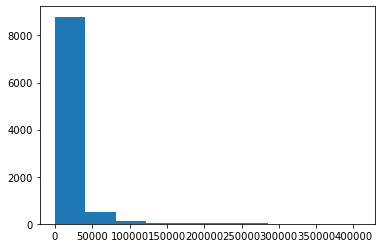

In [15]:
plt.hist(df['revol_bal'])
plt.show()

In [16]:
df.describe()

,credit_policy,int_rate,installment,log_annual_income,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
count,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000
mean,0.805306,0.122626,318.987906,10.931368,12.605836,710.853144,4558.871753,16579.391477,46.785876,1.576353,0.163777,0.062043,0.159912,0.131815,0.413307,0.035826,0.065699,0.045644,0.064445
std,0.395986,0.026838,206.989373,0.613797,6.884394,37.975589,2495.029149,28971.575195,29.010949,2.199344,0.546319,0.262003,0.366544,0.338308,0.492453,0.185866,0.247768,0.208724,0.245557
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.210000,682.000000,2819.968750,3185.500000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.927556,12.665000,707.000000,4139.500000,8582.500000,46.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.260000,11.289832,17.950000,737.000000,5730.000000,18212.750000,70.900000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,407794.000000,119.000000,33.000000,13.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This looks a little better but it is still very skewed. Otherwise, the dataset is complete with a very sufficient sample size.

## D. Run the VIFs to check for multicollinearity. Get rid of any problem variables.

In [17]:
X = df[['credit_policy','int_rate','installment','log_annual_income','dti','fico','days_with_cr_line',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'educational','home_improvement','major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

               feature          VIF
0                const  2049.264825
1        credit_policy     1.696396
2             int_rate     2.955715
3          installment     1.691514
4    log_annual_income     1.595529
5                  dti     1.243233
6                 fico     3.443115
7    days_with_cr_line     1.310953
8            revol_bal     1.480340
9           revol_util     1.789482
10      inq_last_6mths     1.471280
11         delinq_2yrs     1.140923
12             pub_rec     1.051410
13         credit_card     1.410105
14  debt_consolidation     1.766519
15         educational     1.117337
16    home_improvement     1.220587
17      major_purchase     1.138329
18      small_business     1.305744


All VIFs are under 5, no problems with multicollinearity here

## E. What are the assumptions? Are they met here? Use evidence from C and D to support your answer.

No Outliers: We cleaned a few up but there might be some left. Will see what the regression analaysis tells us

Large Sample: we are well over the required 500 observations.

Binary Dependent Variable: "not_fully_paid" is a 0/1 binary variable

No Multicollinearity: From part D, all VIFs are under 5. Good to go

## F. Create a logistic regression model with not_fully_paid as your dependent variable and all of the variables as independent, then iteratively drop insignificant factors until we reach a model with all significant variables.

In [19]:
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.409621
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9555
Method:                           MLE   Df Model:                           18
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06804
Time:                        14:31:11   Log-Likelihood:                -3921.7
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                5.313e-110
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.7151      1.294      6.737      0.000       6.180      11.251
credi

In [20]:
X = df[['credit_policy','int_rate','installment','log_annual_income','fico','days_with_cr_line',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'educational','home_improvement','major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.409625
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9556
Method:                           MLE   Df Model:                           17
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06803
Time:                        14:31:11   Log-Likelihood:                -3921.7
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                9.304e-111
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.6905      1.291      6.733      0.000       6.161      11.220
credi

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
X = df[['credit_policy','int_rate','installment','log_annual_income','fico','days_with_cr_line',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'home_improvement','major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.409634
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9557
Method:                           MLE   Df Model:                           16
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06801
Time:                        14:31:11   Log-Likelihood:                -3921.8
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                1.674e-111
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.7342      1.287      6.788      0.000       6.212      11.256
credi

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
X = df[['credit_policy','int_rate','installment','log_annual_income','fico','days_with_cr_line',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.409658
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9558
Method:                           MLE   Df Model:                           15
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06795
Time:                        14:31:12   Log-Likelihood:                -3922.1
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                3.324e-112
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.6856      1.285      6.761      0.000       6.168      11.203
credi

In [23]:
X = df[['credit_policy','int_rate','installment','log_annual_income','fico',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.409692
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9559
Method:                           MLE   Df Model:                           14
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06787
Time:                        14:31:12   Log-Likelihood:                -3922.4
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                7.016e-113
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.4322      1.246      6.769      0.000       5.991      10.874
credi

In [24]:
X = df[['credit_policy','installment','log_annual_income','fico',
        'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec','credit_card','debt_consolidation',
        'major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.409744
         Iterations 6


C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9560
Method:                           MLE   Df Model:                           13
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06776
Time:                        14:31:12   Log-Likelihood:                -3922.9
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                1.683e-113
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.2292      0.956      9.650      0.000       7.355      11.104
credit_policy         -0.3057      0.085     -3.613      0.000      -0.472      -0.140
installment         

In [25]:
X = df[['credit_policy','installment','log_annual_income','fico',
        'revol_bal','revol_util','inq_last_6mths','pub_rec','credit_card','debt_consolidation',
        'major_purchase','small_business']]
X = sm.add_constant(X)
y = df['not_fully_paid']
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.409857
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9561
Method:                           MLE   Df Model:                           12
Date:                Tue, 16 Nov 2021   Pseudo R-squ.:                 0.06750
Time:                        14:31:12   Log-Likelihood:                -3924.0
converged:                       True   LL-Null:                       -4208.0
Covariance Type:            nonrobust   LLR p-value:                6.920e-114
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.9828      0.941      9.543      0.000       7.138      10.828
credi

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## G. Interpret what each of these coefficients mean. Do these interpretations make sense?

After a few itterations and dropping the insignificant variables we arrive at the above model. Lets discuss the coefficients:

credit_policy: Meeting the credit policy of lending club reduces probabilty of not paying back. Matches our original hypothesis

installment: Higher payments, higher chance of not paying back. Matches our original hypothesis

log_annual_income: Higher annual income, lower chance of not paying back. Matches our original hypothesis

fico: Higher FICO, lower chance of not paying back. Matches our original hypothesis

revol_bal: Higher revolving balance, higher chance of not paying back. Matches our original hypothesis

revol_util: Higher percent of credit line used, higher chance of not paying back. Matches our original hypothesis

inq_last_6mths: More creditors calling them, higher chance of them not paying back. Matches our original hypothesis

pub_rec: More negative reports, higher chance of them not paying back. Matches our original hypothesis

credit_card: If they are using loan for credit card payment, it lowers the chance they will not pay it back

debt_consolidation: If they are using loan for debt consolidation, it lowers the chance they will not pay it back

major_purchases: If they are using loan for a major purchase, it lowers the chance they will not pay it back

small business: If they are using loan for small business, it increases the chance they will not pay it back

## H. What is the overall fit of the model? Interpret what it means. Is it good? 

The overall fit is the Pseudo R-Squared of the model which is .0675. This means that 6.75% of the variation in someone paying their loan back or not can be explained by our model. This is NOT good. There is over 93% of the variation in our model that is unexplained. We should find other variables to consider to help us determin if someone will pay the loan back or not.

## 2. Baseball Linear Regression

In [26]:
df = pd.read_csv('baseball.csv')

In [27]:
df.head(5)

,Team,League,Year,RS,OBP,SLG,BA
0,ARI,NL,2012,734,0.328,0.418,0.259
1,ATL,NL,2012,700,0.320,0.389,0.247
2,BAL,AL,2012,712,0.311,0.417,0.247
3,BOS,AL,2012,734,0.315,0.415,0.260
4,CHC,NL,2012,613,0.302,0.378,0.240


## A. What is the expected outcome for EACH X variable on RS? Will it increase or decrease runs? 

OBP: Higher on Base Percentage will increase the number of Runs Scored

SLG: Higher Slugging Percentage will increase the number of Runs Scored

BA: Higher Batting Average will increase the number of Runs Scored

## B. Run the summary statistics to check for complete data and no outliers.

In [28]:
df.describe()

,Year,RS,OBP,SLG,BA
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,1988.957792,715.081981,0.326331,0.397342,0.259273
std,14.819625,91.534294,0.015013,0.033267,0.012907
min,1962.000000,463.000000,0.277000,0.301000,0.214000
25%,1976.750000,652.000000,0.317000,0.375000,0.251000
50%,1989.000000,711.000000,0.326000,0.396000,0.260000
75%,2002.000000,775.000000,0.337000,0.421000,0.268000
max,2012.000000,1009.000000,0.373000,0.491000,0.294000


## C. Create the pair plot to check the linearity and no multicollinearity assumptions.

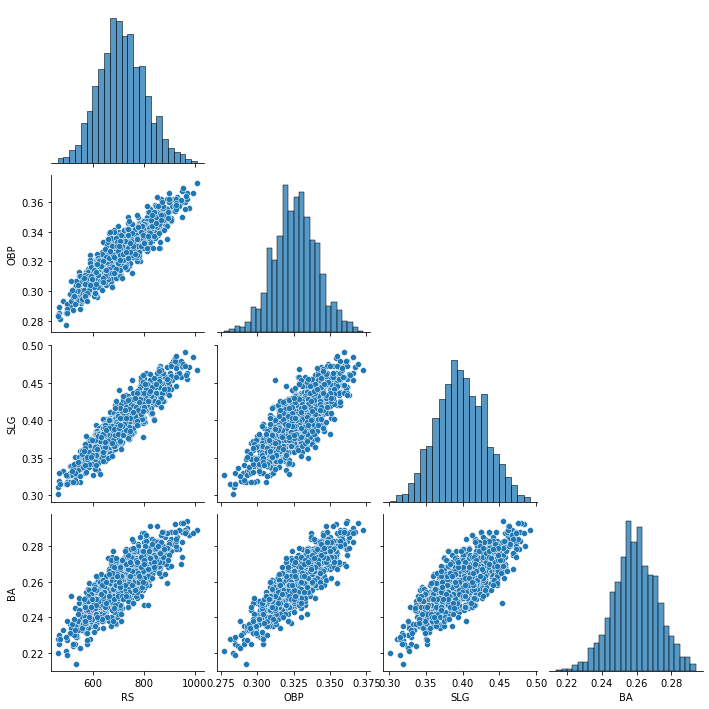

In [29]:
sns.pairplot(df,x_vars=['RS','OBP','SLG','BA'],y_vars=['RS','OBP','SLG','BA'],corner=True)
plt.show()

## D. Run the VIFs to check for multicollinearity. Get rid of any problem variables.

In [30]:
X=df[['OBP','SLG','BA']]
X = sm.add_constant(X)
y=df['RS']

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

  feature         VIF
0   const  590.665922
1     OBP    4.212412
2     SLG    3.078599
3      BA    4.204787


## E. Create a linear regression model with RS as the dependent variable and OBP, SLG, and BA as you independent variables. Then, iteratively drop insignificant factors until we reach a model with all significant variables.

In [32]:
model = sm.OLS(y,X).fit()
y_pred = model.predict(X)
resid = y - y_pred
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     5040.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:31:14   Log-Likelihood:                -5717.6
No. Observations:                1232   AIC:                         1.144e+04
Df Residuals:                    1228   BIC:                         1.146e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -806.0845     17.392    -46.348      0.0

In [33]:
X=df[['OBP','SLG']]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
y_pred = model.predict(X)
resid = y - y_pred
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     7557.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:31:14   Log-Likelihood:                -5718.3
No. Observations:                1232   AIC:                         1.144e+04
Df Residuals:                    1229   BIC:                         1.146e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -811.6624     16.747    -48.467      0.0

C:\Users\rleach\anaconda3\envs\cosc\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## F. Interpret what each of these coefficients mean. Do these interpretations make sense?

We dropped out Batting Average becasue it was insignificant. Here is how we interpret the rest of the model:
    
OBP: Holding all else constant, increasing the on base percentage by 1 percentage point would increase runs scored by 28.3 on average

SLG: Holding all else constant, increasing the slugging percentage by 1 percentage point would increase runs scored by 15.17 on average

## G. What is the overall fit of the model? Interpret what it means. Is it good?

The overall fit is the R-Squared of the model which is .925. This means that 92.5% of the variation in Runs Scored can be explained by our model. This is excellent. There is over 7% of the variation in our model that is unexplained. I think if a baseball team is tryting to build a model for explaining Runs Scored over a season, this simple model is quite powerful.

## H. Using the predicted values and residuals, create the diagnostic graphs to check the assumptions of Linearity, Normality, and Homoscedasticity.

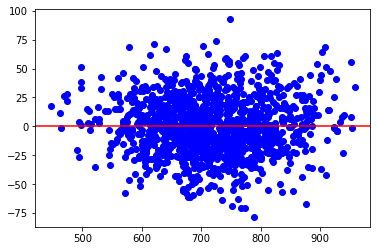

In [34]:
plt.scatter(y_pred,resid,color='b')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

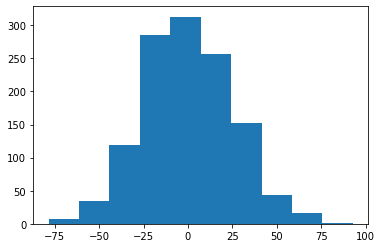

In [35]:
plt.hist(resid)
plt.show()

## I. Go through each assumption of linear regression and say if it was met or not.

Linearity: Looks good from the pairplot and residual plot. Pass!

Normality: Histogram of residuals looks normal. Pass!

Constant Variance: Residual Plot looks good. Pass!

No Multicollinearity: VIFs all under 5. Pass!

No Autocorrelation: This may be violated because we are dealing with data of the same teams but over different time periods

## 3. NLP

## A. Parts-of-Speech Tagging

In [36]:
blob_grimm = TextBlob(Path('grimm.txt').read_text(encoding='utf-8'))
blob_andersen = TextBlob(Path('andersen.txt').read_text(encoding='utf-8'))

In [37]:
blob_grimm.tags

[('\ufeffGrimms', 'JJ'),
 ('’', 'NNP'),
 ('Fairy', 'NNP'),
 ('Tales', 'NNP'),
 ('By', 'IN'),
 ('Jacob', 'NNP'),
 ('Grimm', 'NNP'),
 ('and', 'CC'),
 ('Wilhelm', 'NNP'),
 ('Grimm', 'NNP'),
 ('THE', 'NNP'),
 ('GOLDEN', 'NNP'),
 ('BIRD', 'NNP'),
 ('A', 'NNP'),
 ('certain', 'JJ'),
 ('king', 'NN'),
 ('had', 'VBD'),
 ('a', 'DT'),
 ('beautiful', 'JJ'),
 ('garden', 'NN'),
 ('and', 'CC'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('garden', 'NN'),
 ('stood', 'VBD'),
 ('a', 'DT'),
 ('tree', 'NN'),
 ('which', 'WDT'),
 ('bore', 'VBD'),
 ('golden', 'JJ'),
 ('apples', 'NNS'),
 ('These', 'DT'),
 ('apples', 'NNS'),
 ('were', 'VBD'),
 ('always', 'RB'),
 ('counted', 'VBN'),
 ('and', 'CC'),
 ('about', 'IN'),
 ('the', 'DT'),
 ('time', 'NN'),
 ('when', 'WRB'),
 ('they', 'PRP'),
 ('began', 'VBD'),
 ('to', 'TO'),
 ('grow', 'VB'),
 ('ripe', 'VB'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('found', 'VBN'),
 ('that', 'IN'),
 ('every', 'DT'),
 ('night', 'NN'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('them', 'PRP'),
 ('was', 'VBD'),
 ('g

In [38]:
blob_andersen.tags

[('\ufeffANDERSEN', 'NN'),
 ("'S", 'POS'),
 ('FAIRY', 'NNP'),
 ('TALES', 'NNP'),
 ('By', 'IN'),
 ('Hans', 'NNP'),
 ('Christian', 'NNP'),
 ('Andersen', 'NNP'),
 ('THE', 'NNP'),
 ('EMPEROR', 'NNP'),
 ("'S", 'POS'),
 ('NEW', 'NNP'),
 ('CLOTHES', 'NNP'),
 ('Many', 'NNP'),
 ('years', 'NNS'),
 ('ago', 'RB'),
 ('there', 'EX'),
 ('was', 'VBD'),
 ('an', 'DT'),
 ('Emperor', 'NNP'),
 ('who', 'WP'),
 ('was', 'VBD'),
 ('so', 'RB'),
 ('excessively', 'RB'),
 ('fond', 'NN'),
 ('of', 'IN'),
 ('new', 'JJ'),
 ('clothes', 'NNS'),
 ('that', 'IN'),
 ('he', 'PRP'),
 ('spent', 'VBD'),
 ('all', 'PDT'),
 ('his', 'PRP$'),
 ('money', 'NN'),
 ('in', 'IN'),
 ('dress', 'NN'),
 ('He', 'PRP'),
 ('did', 'VBD'),
 ('not', 'RB'),
 ('trouble', 'NN'),
 ('himself', 'PRP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('least', 'JJS'),
 ('about', 'IN'),
 ('his', 'PRP$'),
 ('soldiers', 'NNS'),
 ('nor', 'CC'),
 ('did', 'VBD'),
 ('he', 'PRP'),
 ('care', 'VB'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('either', 'RB'),
 ('to', 'TO'),
 ('the', 'DT'),
 (

## B. Noun Phrase Extraction

In [39]:
blob_grimm.noun_phrases

WordList(['\ufeffgrimms ’ fairy', 'tales', 'jacob grimm', 'wilhelm grimm the golden bird', 'certain king', 'beautiful garden', 'golden apples', 'eldest son', 'o ’ clock', 'young man', 'pure gold', 'gardener ’ s son', 'golden feather', 'golden feather', 'everyone', 'whole bird. ’', 'gardener ’ s eldest son', 'golden bird', 'good counsel', 'golden bird', 'mean. ’', 'shabby house', 'charming place ’', 'smart house', 'eldest son', 'good advice', 'eldest brother', 'golden bird', 'wide world', 'golden bird', 'good counsel', 'sit', 'travel faster. ’', 'fox ’ s counsel', 'shabby inn', 'whole troop', 'fast asleep', 'golden bird sits', 'wooden cage', 'beautiful golden cage', 'shabby cage', 'repent it. ’', 'young man', 'stone till', 'castle gate', 'golden bird', 'wooden cage', 'golden cage', 'golden apples', 'droll thing', 'fine bird', 'shabby cage ’', 'golden cage', 'loud scream', 'golden horse', 'golden bird', 'great despair', 'golden horse', 'horse stands', 'fast asleep', 'old leathern saddle'

In [40]:
blob_andersen.noun_phrases

WordList(["\ufeffandersen 's", 'fairy tales', 'hans', 'andersen the emperor', 'new clothes', 'emperor', 'new clothes', 'new clothes', 'different suit', 'emperor', 'wardrobe. ” time', 'large town', 'weave stuffs', 'beautiful colors', 'wonderful property', 'splendid clothes', 'emperor', 'immediately. ”', 'large sums', 'delicate silk', 'gold thread', 'own knapsacks', 'empty looms', 'emperor', 'own person', 'wonderful property', 'old minister', 'emperor', 'is. ”', 'old minister', 'empty looms', 'old man', 'looms. ”', 'empty frames', 'poor old minister', 'good reason', 'stuff. ” “', 'well', 'sir', 'stuff pleases you. ” “', 'oh', 'old minister', 'emperor', 'them. ” “', 'different colors', 'old minister', 'emperor', 'apparent diligence', 'empty looms', 'emperor', 'empty frames', 'does', 'emperor', 'time making', 'profitable office', 'it. ”', 'majesty', 'magnificent. ”', 'whole city', 'splendid cloth', 'emperor', 'own expense', 'emperor', 'costly manufacture', 'accompanied', 'select number', '

## C. Named Entity Recognition

In [41]:
nlp = spacy.load("en_core_web_sm")
doc_grimm = nlp(Path('grimm.txt').read_text(encoding='utf-8'))
doc_andersen = nlp(Path('andersen.txt').read_text(encoding='utf-8'))

In [51]:
for entity in doc_grimm.ents:
    print(f'{entity.text}:{entity.label_}')

’ Fairy Tales

:WORK_OF_ART
Jacob Grimm:PERSON
Wilhelm Grimm:PERSON
THE GOLDEN BIRD:ORG
every night:TIME
all night:TIME
about twelve o’clock:TIME
second:ORDINAL
midnight:TIME
third:ORDINAL
first:ORDINAL
twelve:CARDINAL
one:CARDINAL
the
council:ORG
two:CARDINAL
one:CARDINAL
evening:TIME
two:CARDINAL
second:ORDINAL
two:CARDINAL
Time:ORG
the morning:TIME
three:CARDINAL
twelve:CARDINAL
twelve:CARDINAL
first:ORDINAL
eight days:DATE
seven days:DATE
Lie:PERSON
three:CARDINAL
gallop:ORG
two:CARDINAL
two:CARDINAL
Two:CARDINAL
two:CARDINAL
first:ORDINAL
two:CARDINAL
one day:DATE
HANS:PERSON
geese:NORP
One:CARDINAL
Hans:PERSON
Seven long years:DATE
Hans:PERSON
Hans:PERSON
one foot:QUANTITY
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:NORP
Hans:PERSON
last penny:MONEY
noon:TIME
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
Hans:PERSON
weeks:DATE
Hans:PERSON
Hans:PERSON
First:ORDINAL
six months:DATE
dale
  :PERSON
Hans:PERSON
seven:CARDINAL
Hans:PERSON


In [52]:
for entity in doc_andersen.ents:
    print(f'{entity.text}:{entity.label_}')

﻿ANDERSEN'S FAIRY TALES

:WORK_OF_ART
Hans Christian Andersen:PERSON
each hour:TIME
the day:DATE
Time:ORG
every day:DATE
One day:DATE
two:CARDINAL
two:CARDINAL
two:CARDINAL
late at night:TIME
one:CARDINAL
Emperor:ORG
second:ORDINAL
one:CARDINAL
Imperial Majesty:ORG
two:CARDINAL
Emperor:ORG
two:CARDINAL
two:CARDINAL
Gentlemen Weavers:WORK_OF_ART
the night:TIME
sixteen:CARDINAL
Majesty:PERSON
Imperial Majesty:ORG
Majesty:PERSON
hundred:CARDINAL
Prince:PERSON
five years:DATE
only one:CARDINAL
Prince:ORG
Superbe!:WORK_OF_ART
French:LANGUAGE
one:CARDINAL
Empress:ORG
Imperial Swineherd:WORK_OF_ART
Augustin:ORG
Augustine:PERSON
Lieber
Augustine:WORK_OF_ART
first:ORDINAL
ten:CARDINAL
Augustin:ORG
ten:CARDINAL
Ten:CARDINAL
ten:CARDINAL
the following day:DATE
hundred:CARDINAL
I am the Emperor's:WORK_OF_ART
yesterday:DATE
ten:CARDINAL
A hundred:CARDINAL
eighty-sixth:QUANTITY
March:DATE
Alas!:WORK_OF_ART
Thou:PERSON
Thou:PERSON
thou:GPE
Thou:PERSON
Augustin:ORG
THE REAL PRINCESS

:LAW
One evening:

Kay:PERSON
two:CARDINAL
Coo:PERSON
Coo:PERSON
Gerda:PERSON
Lapland:GPE
Reindeer:ORG
Queen:PERSON
summer:DATE
the North Pole:LOC
Spitzbergen:ORG
Kay:PERSON
Kay:PERSON
Gerda:PERSON
the morning:TIME
Gerda:PERSON
Wood:PERSON
Lapland:GPE
Reindeer:ORG
Gerda:PERSON
Reindeer:ORG
Lapland:GPE
the Snow Queen:WORK_OF_ART
Gerda:PERSON
Gerda:PERSON
two:CARDINAL
Reindeer:ORG
Gerda:PERSON
Reindeer:ORG
bush:PERSON
Ddsa:PERSON
Ddsa:PERSON
Reindeer:ORG
Lapland:GPE
The Lapland Woman:ORG
the Finland Woman:ORG
Lapland:PERSON
Reindeer:ORG
Gerda:PERSON
first:ORDINAL
Gerda:PERSON
Lapland:ORG
more than a hundred miles:CARDINAL
Finland:GPE
the Snow Queen:WORK_OF_ART
Finland:GPE
Gerda:PERSON
Lapland:GPE
Gerda:PERSON
Reindeer:ORG
Ddsa:PERSON
Ddsa:PERSON
Finland:GPE
Finland:GPE
Finland:GPE
Gerda:PERSON
Reindeer:ORG
three:CARDINAL
Reindeer:ORG
first:ORDINAL
Gerda:PERSON
Finland:GPE
Reindeer:ORG
one:CARDINAL
second:ORDINAL
third:ORDINAL
fourth:ORDINAL
twelve:CARDINAL
the Snow Queen:PERSON
twelve:CARDINAL
Finland:GPE


## D. Remove the stop words and then get the most common words for each and make a bar chart of the top 20.

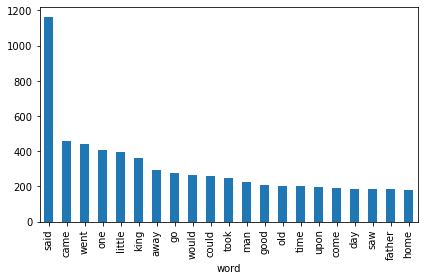

In [68]:
stop_words = stopwords.words('english')
add_words = ['’','‘','”','“']
for i in range(len(add_words)):
    stop_words.append(add_words[i])

items = blob_grimm.word_counts.items()
items = [item for item in items if item[0] not in stop_words]
items = [item for item in items if item[0] not in stop_words]
sorted_items = sorted(items, key=itemgetter(1), reverse=True)
top20 = sorted_items[0:21]
df = pd.DataFrame(top20, columns=['word', 'count'])
axes = df.plot.bar(x='word', y='count', legend=False)
plt.gcf().tight_layout()

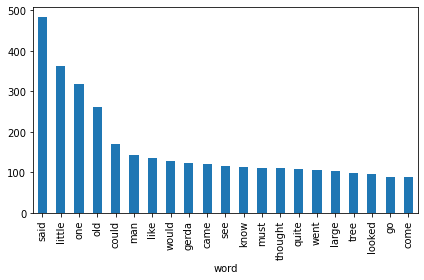

In [69]:
items = blob_andersen.word_counts.items()
items = [item for item in items if item[0] not in stop_words]
sorted_items = sorted(items, key=itemgetter(1), reverse=True)
top20 = sorted_items[0:21]
df = pd.DataFrame(top20, columns=['word', 'count'])
axes = df.plot.bar(x='word', y='count', legend=False)
plt.gcf().tight_layout()

## E. Create a word cloud for each. Play around with the color options.

https://matplotlib.org/stable/tutorials/colors/colormaps.html

Here is the link to the color options for MatPlotLib

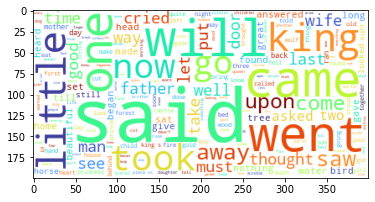

In [44]:
text_grimm = Path('grimm.txt').read_text(encoding='utf-8')
wordcloud = WordCloud(colormap='turbo',background_color='white')
wordcloud = wordcloud.generate(text_grimm)
wordcloud = wordcloud.to_file('grimm.png')
plt.imshow(wordcloud)

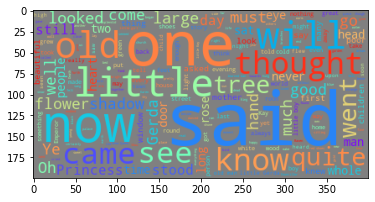

In [45]:
text_andersen = Path('andersen.txt').read_text(encoding='utf-8')
wordcloud = WordCloud(colormap='rainbow',background_color='grey')
wordcloud = wordcloud.generate(text_andersen)
wordcloud = wordcloud.to_file('andersen.png')
plt.imshow(wordcloud)

## F. Sentiment Analysis. How do the two books compare in overall tone and objectivity?

In [46]:
blob_grimm.sentiment

Sentiment(polarity=0.10672418445536225, subjectivity=0.48485202483089174)

In [47]:
blob_andersen.sentiment

Sentiment(polarity=0.12057141974998299, subjectivity=0.5024690815700998)

Sentinment betweent the two is very similar. Both books are about neutral but leaning slightly positive in terms of sentiment polarity. Both are around the same subjectivity being almost exactly in the middle of the Objectivity/Subjectivity scores. 

## G. Readability Scores. How do the two books compare in overall readability?

In [48]:
readability = Textatistic(text_grimm)
readability.dict()

{'char_count': 415286,
 'word_count': 101182,
 'sent_count': 4540,
 'sybl_count': 113891,
 'notdalechall_count': 10321,
 'polysyblword_count': 1175,
 'flesch_score': 88.98770192479084,
 'fleschkincaid_score': 6.383988883903278,
 'gunningfog_score': 9.379223154124418,
 'smog_score': 6.035369891220832,
 'dalechall_score': 6.352572533557317}

In [49]:
readability = Textatistic(text_andersen)
readability.dict()

{'char_count': 242083,
 'word_count': 56070,
 'sent_count': 3133,
 'sybl_count': 66355,
 'notdalechall_count': 7118,
 'polysyblword_count': 1675,
 'flesch_score': 88.55166793041919,
 'fleschkincaid_score': 5.354158864845145,
 'gunningfog_score': 8.353568800023181,
 'smog_score': 7.306173758067762,
 'dalechall_score': 6.528686743794278}

Both of these books score very similar on the readability scores. They look to be around a middle school/junior high reading level depending on the measure we look at. The Dale-Chall score is the one used most for a broad range of texts and this tells us both books are at a 6th grade reading level.

## H. Calculate the similarity recognition between the two books. Interpret the value of this score.

In [50]:
doc_grimm.similarity(doc_andersen)

C:\Users\rleach\AppData\Local\Temp/ipykernel_7700/628344173.py:1: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  doc_grimm.similarity(doc_andersen)


0.9474072790207654

This is similar to a correlation but for text docuements. It is very close to one meaning that both books are very similar. This isn't too surprising considering both are books of fairy tales.

## 4. What is an API? What are APIs used for?

An API is an Application Programming Interface. APIs are used for two programs to communicate with one another. They are useful because we do not need to know how the other program is written or structured. We can follow their API documentation to gather the information we need for our program. This allows the creators of an API to let users have access to specific pieces of information without giving up the keys to the castle.